In [ ]:
!pip install pmdarima
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statsmodels.api as sm
import itertools
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from scipy.spatial.distance import cdist

In [ ]:
data_f=pd.read_csv('PT_Train.csv')
print('shape of data',data_f.shape)
data_f.head()

shape of data (226, 5)


,Timestamp (GMT),Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
0,17/08/2015 15:09,139,41,NaN,NaN
1,17/08/2015 15:10,144,40,92.0,140.0
2,17/08/2015 15:11,140,42,89.0,144.0
3,17/08/2015 15:12,138,45,93.0,141.0
4,17/08/2015 15:13,133,42,94.0,134.0


In [ ]:
ev_df = data_f.loc[data_f['Lifetouch Heart Rate']>= 1000]
print(ev_df)
print(data_f)

     Timestamp (GMT)  Lifetouch Heart Rate  ...  Oximeter SpO2  Oximeter Pulse
30  17/08/2015 15:39                 61441  ...           94.0           152.0
31  17/08/2015 15:40                 61442  ...           92.0           146.0
32  17/08/2015 15:41                 61441  ...           -1.0            -1.0
33  17/08/2015 15:42                 61441  ...           98.0           143.0
34  17/08/2015 15:43                 61441  ...           97.0           142.0
35  17/08/2015 15:44                 61441  ...           96.0           140.0
36  17/08/2015 15:45                 61442  ...           96.0           144.0
41  17/08/2015 15:50                 61442  ...           94.0           148.0

[8 rows x 5 columns]
      Timestamp (GMT)  Lifetouch Heart Rate  ...  Oximeter SpO2  Oximeter Pulse
0    17/08/2015 15:09                   139  ...            NaN             NaN
1    17/08/2015 15:10                   144  ...           92.0           140.0
2    17/08/2015 15:11      

In [ ]:
og_data=data_f.loc[data_f['Lifetouch Heart Rate']<= 500 ]
print(og_data)

      Timestamp (GMT)  Lifetouch Heart Rate  ...  Oximeter SpO2  Oximeter Pulse
0    17/08/2015 15:09                   139  ...            NaN             NaN
1    17/08/2015 15:10                   144  ...           92.0           140.0
2    17/08/2015 15:11                   140  ...           89.0           144.0
3    17/08/2015 15:12                   138  ...           93.0           141.0
4    17/08/2015 15:13                   133  ...           94.0           134.0
..                ...                   ...  ...            ...             ...
221  17/08/2015 18:50                   159  ...            NaN             NaN
222  17/08/2015 18:51                   151  ...            NaN             NaN
223  17/08/2015 18:52                   140  ...            NaN             NaN
224  17/08/2015 18:53                   140  ...            NaN             NaN
225  17/08/2015 18:54                   138  ...            NaN             NaN

[218 rows x 5 columns]


In [ ]:
from datetime import datetime
con=og_data['Timestamp (GMT)']
og_data['Timestamp (GMT)']=pd.to_datetime(og_data['Timestamp (GMT)'])
og_data.set_index('Timestamp (GMT)', inplace=True)
#check datatype of index
og_data.index

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


DatetimeIndex(['2015-08-17 15:09:00', '2015-08-17 15:10:00',
               '2015-08-17 15:11:00', '2015-08-17 15:12:00',
               '2015-08-17 15:13:00', '2015-08-17 15:14:00',
               '2015-08-17 15:15:00', '2015-08-17 15:16:00',
               '2015-08-17 15:17:00', '2015-08-17 15:18:00',
               ...
               '2015-08-17 18:45:00', '2015-08-17 18:46:00',
               '2015-08-17 18:47:00', '2015-08-17 18:48:00',
               '2015-08-17 18:49:00', '2015-08-17 18:50:00',
               '2015-08-17 18:51:00', '2015-08-17 18:52:00',
               '2015-08-17 18:53:00', '2015-08-17 18:54:00'],
              dtype='datetime64[ns]', name='Timestamp (GMT)', length=218, freq=None)

In [ ]:
og_data.tail()

,Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
Timestamp (GMT),,,,
2015-08-17 18:50:00,159,51,NaN,NaN
2015-08-17 18:51:00,151,64,NaN,NaN
2015-08-17 18:52:00,140,64,NaN,NaN
2015-08-17 18:53:00,140,55,NaN,NaN
2015-08-17 18:54:00,138,54,NaN,NaN


In [ ]:
og_data

,Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
Timestamp (GMT),,,,
2015-08-17 15:09:00,139,41,NaN,NaN
2015-08-17 15:10:00,144,40,92.0,140.0
2015-08-17 15:11:00,140,42,89.0,144.0
2015-08-17 15:12:00,138,45,93.0,141.0
2015-08-17 15:13:00,133,42,94.0,134.0
...,...,...,...,...
2015-08-17 18:50:00,159,51,NaN,NaN
2015-08-17 18:51:00,151,64,NaN,NaN
2015-08-17 18:52:00,140,64,NaN,NaN


In [ ]:
og_data['Lifetouch Heart Rate'].size

218

In [ ]:
og_data.isnull().sum()

Lifetouch Heart Rate           0
Lifetouch Respiration Rate     0
Oximeter SpO2                 35
Oximeter Pulse                35
dtype: int64

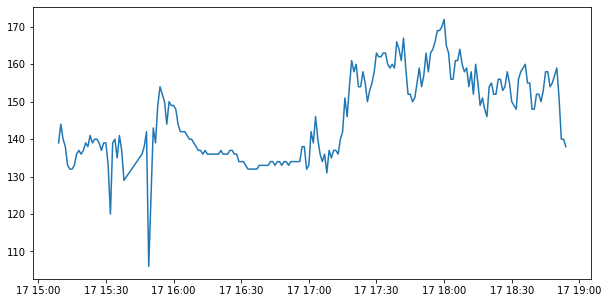

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(og_data.index, og_data["Lifetouch Heart Rate"], label='original')

### **Dickey Fuller Test**

In [ ]:
from statsmodels.tsa.stattools import adfuller
def adfuller_test(database):
  dftest = adfuller(database, autolag = 'AIC')
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :",dftest[4])
  for key, val in dftest[4].items():
    print("\t",key, ": ", val)


In [ ]:
adfuller_test(og_data['Lifetouch Heart Rate'])

1. ADF :  -2.3604265607058403
2. P-Value :  0.1532185464358677
3. Num Of Lags :  1
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 216
5. Critical Values : {'1%': -3.4609922013325267, '5%': -2.875015740963014, '10%': -2.5739524288408777}
	 1% :  -3.4609922013325267
	 5% :  -2.875015740963014
	 10% :  -2.5739524288408777


### **Differencing method**

In [ ]:
og_data['Minutes Difference'] = og_data['Lifetouch Heart Rate']-og_data['Lifetouch Heart Rate'].shift(4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


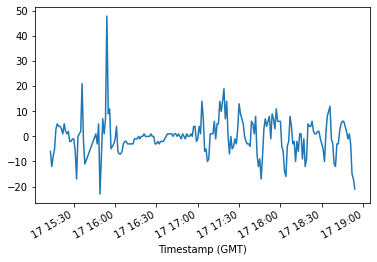

In [ ]:
og_data['Minutes Difference'].dropna().plot()

In [ ]:
og_data.head(218)

,Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse,Minutes Difference
Timestamp (GMT),,,,,
2015-08-17 15:09:00,139,41,NaN,NaN,NaN
2015-08-17 15:10:00,144,40,92.0,140.0,NaN
2015-08-17 15:11:00,140,42,89.0,144.0,NaN
2015-08-17 15:12:00,138,45,93.0,141.0,NaN
2015-08-17 15:13:00,133,42,94.0,134.0,-6.0
...,...,...,...,...,...
2015-08-17 18:50:00,159,51,NaN,NaN,1.0
2015-08-17 18:51:00,151,64,NaN,NaN,-3.0
2015-08-17 18:52:00,140,64,NaN,NaN,-15.0


In [ ]:
adfuller_test(og_data['Minutes Difference'].dropna())

1. ADF :  -3.9353979424262286
2. P-Value :  0.0017892434622948385
3. Num Of Lags :  15
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 198
5. Critical Values : {'1%': -3.4638151713286316, '5%': -2.876250632135043, '10%': -2.574611347821651}
	 1% :  -3.4638151713286316
	 5% :  -2.876250632135043
	 10% :  -2.574611347821651


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


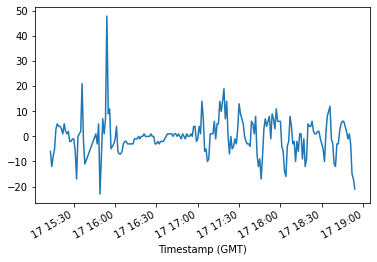

In [ ]:
og_data['Lifetouch Heart Rate_diff_4'] = og_data['Lifetouch Heart Rate'] - og_data['Lifetouch Heart Rate'].shift(4)
og_data['Lifetouch Heart Rate_diff_4'].dropna().plot()

### ***Tranforming the data***

In [ ]:
# Create transformation columns
import numpy as np

# Calculate the log
og_data['adj_log'] = np.log(og_data['Lifetouch Heart Rate'])

# Calculate the square root
og_data['adj_sqrt'] = np.sqrt(og_data['Lifetouch Heart Rate'])

# Calculate the cubed root
og_data['adj_cbrt'] = np.cbrt(og_data['Lifetouch Heart Rate'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

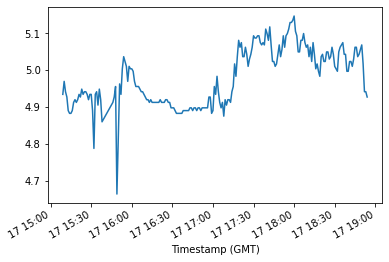

In [ ]:
og_data['adj_log'].dropna().plot()

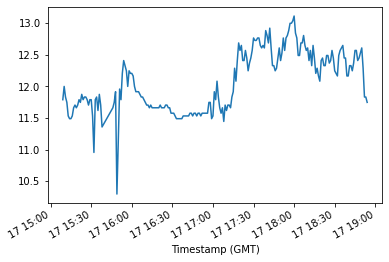

In [ ]:
og_data['adj_sqrt'].dropna().plot()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


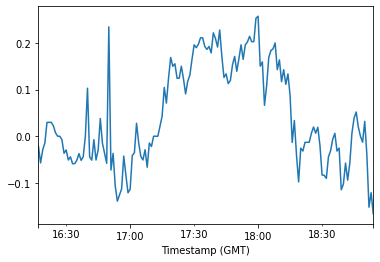

In [ ]:
og_data['Lifetouch Heart Rate_log_diff'] = og_data['adj_log'] - og_data['adj_log'].shift(60)
og_data['Lifetouch Heart Rate_log_diff'].dropna().plot()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


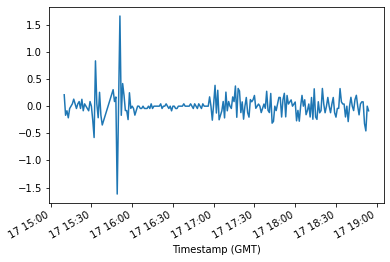

In [ ]:
og_data['Lifetouch Heart Rate_sqrt_diff'] = og_data['adj_sqrt'] - og_data['adj_sqrt'].shift(1)
og_data['Lifetouch Heart Rate_sqrt_diff'].dropna().plot()

### **Rolling Statistics**

In [ ]:
og_data['#MA10'] = og_data['Lifetouch Heart Rate'].rolling(window = 10 ).mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


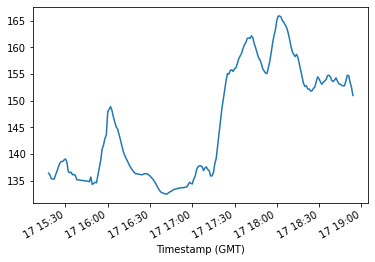

In [ ]:
og_data['#MA10'].dropna().plot()

In [ ]:
adfuller_test(og_data['Minutes Difference'].dropna())

1. ADF :  -3.9353979424262286
2. P-Value :  0.0017892434622948385
3. Num Of Lags :  15
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 198
5. Critical Values : {'1%': -3.4638151713286316, '5%': -2.876250632135043, '10%': -2.574611347821651}
	 1% :  -3.4638151713286316
	 5% :  -2.876250632135043
	 10% :  -2.574611347821651


### **Auto Regressive Model**

<function matplotlib.pyplot.show>

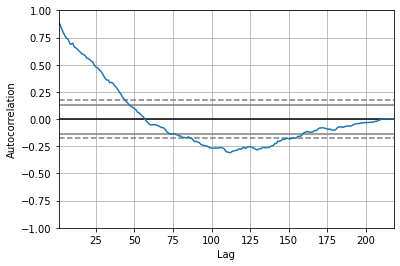

In [ ]:
import pydot
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(og_data['Lifetouch Heart Rate'])
plt.show

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


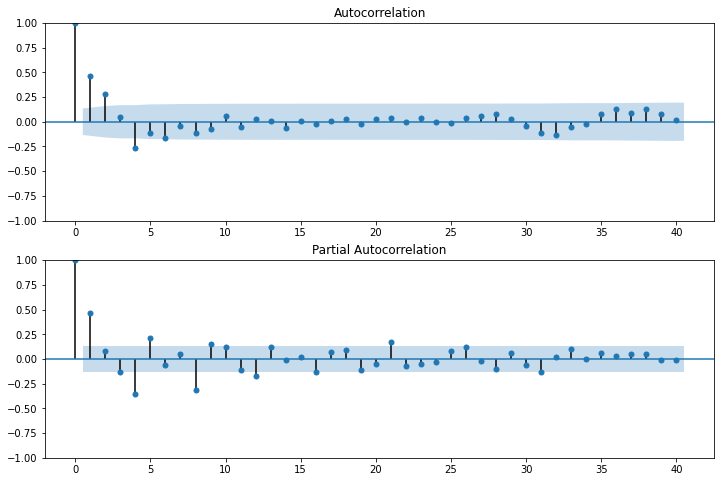

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(og_data['Minutes Difference'].iloc[4:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(og_data['Minutes Difference'].iloc[4:],lags=40,ax=ax2)

## **SARIMA Model**

In [ ]:
from pmdarima import auto_arima
# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
stepwise_fit = auto_arima(og_data["Lifetouch Heart Rate"], trace=True,
                          supress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1306.664, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1335.460, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1307.913, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1304.325, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1333.460, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1306.307, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1306.315, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1308.286, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1302.325, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1304.307, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1304.315, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1305.915, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1306.286, Time=0.20 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.390 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  218
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -649.163
Date:                Fri, 18 Feb 2022   AIC                           1302.325
Time:                        23:16:14   BIC                           1309.085
Sample:                             0   HQIC                          1305.056
                                - 218                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4090      0.032    -12.976      0.000      -0.471      -0.347
sigma2        23.2044      0.955     24.296      0.000      21.332      25.076
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1528.16
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                            -1.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

### **Split Data into Training and Testing**

In [ ]:
print(og_data.shape)
train=og_data.iloc[:-30]
test=og_data.iloc[-30:]
print(train.shape,test.shape)

(218, 12)
(188, 12) (30, 12)


In [ ]:
model = sm.tsa.statespace.SARIMAX(og_data['Lifetouch Heart Rate'],
                                  order=(0, 1, 2),
                                  seasonal_order=(0, 0, 0, 10),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
#train model
model_fit = model.fit()
print(model_fit.summary())

                                SARIMAX Results                                 
Dep. Variable:     Lifetouch Heart Rate   No. Observations:                  218
Model:                 SARIMAX(0, 1, 2)   Log Likelihood                -640.674
Date:                  Fri, 18 Feb 2022   AIC                           1287.348
Time:                          23:16:14   BIC                           1297.445
Sample:                               0   HQIC                          1291.428
                                  - 218                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4111      0.032    -12.893      0.000      -0.474      -0.349
ma.L2         -0.0097      0.057     -0.170      0.865      -0.122       0.102
sigma2        23.3261      0.971    

In [ ]:
start=len(train)
end=len(train)+len(test)-1
pred=model_fit.predict(start=start,end=end,typ='levels')
pred.index=og_data.index[start:end+1]
print(pred)


Timestamp (GMT)
2015-08-17 18:25:00    154.459915
2015-08-17 18:26:00    155.330284
2015-08-17 18:27:00    153.943099
2015-08-17 18:28:00    153.999252
2015-08-17 18:29:00    156.354592
2015-08-17 18:30:00    155.518042
2015-08-17 18:31:00    152.281835
2015-08-17 18:32:00    150.402909
2015-08-17 18:33:00    149.019818
2015-08-17 18:34:00    153.153542
2015-08-17 18:35:00    155.939607
2015-08-17 18:36:00    157.694661
2015-08-17 18:37:00    159.022448
2015-08-17 18:38:00    156.631373
2015-08-17 18:39:00    155.709809
2015-08-17 18:40:00    151.185641
2015-08-17 18:41:00    149.384660
2015-08-17 18:42:00    150.955696
2015-08-17 18:43:00    151.545232
2015-08-17 18:44:00    150.625153
2015-08-17 18:45:00    152.038630
2015-08-17 18:46:00    155.525982
2015-08-17 18:47:00    156.924906
2015-08-17 18:48:00    155.178493
2015-08-17 18:49:00    155.101810
2015-08-17 18:50:00    156.221319
2015-08-17 18:51:00    157.839135
2015-08-17 18:52:00    153.784816
2015-08-17 18:53:00    145.73391

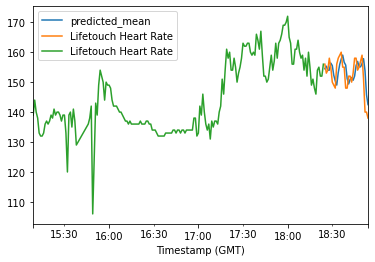

In [ ]:
pred.plot(legend=True)
test['Lifetouch Heart Rate'].plot(legend=True)
train['Lifetouch Heart Rate'].plot(legend=True)

In [ ]:
test['Lifetouch Heart Rate'].mean()

152.63333333333333

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(pred,test['Lifetouch Heart Rate']))
print(rmse)

4.5289265936478165


### **Forecasting**

In [ ]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(og_data['Lifetouch Heart Rate'],order=(0,1,2),seasonal_order=(1,1,1,12))
results=model.fit()

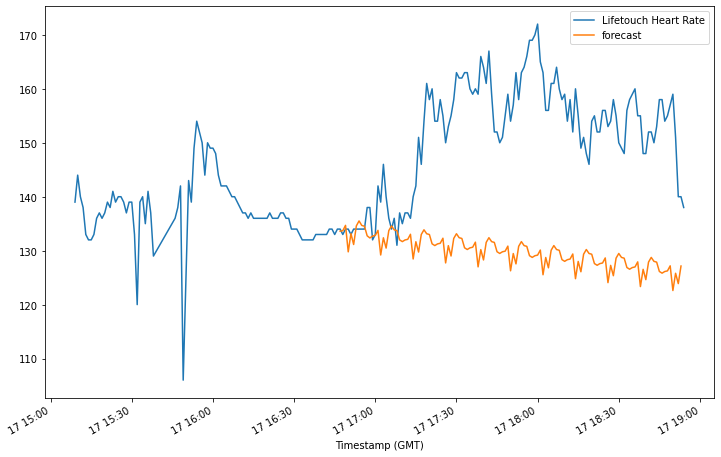

In [ ]:
og_data['forecast']=results.predict(start=90,end=216,dynamic=True)
og_data[['Lifetouch Heart Rate','forecast']].plot(figsize=(12,8))

In [ ]:
from pandas.tseries.offsets import DateOffset
future_dates=[og_data.index[-1]+ DateOffset(minutes=x)for x in range(0,20)]

In [ ]:
future_dataset_og_data=pd.DataFrame(index=future_dates[1:],columns=data_f.columns)

In [ ]:
future_dataset_og_data.tail(5)

,Timestamp (GMT),Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
2015-08-17 19:09:00,NaN,NaN,NaN,NaN,NaN
2015-08-17 19:10:00,NaN,NaN,NaN,NaN,NaN
2015-08-17 19:11:00,NaN,NaN,NaN,NaN,NaN
2015-08-17 19:12:00,NaN,NaN,NaN,NaN,NaN
2015-08-17 19:13:00,NaN,NaN,NaN,NaN,NaN


In [ ]:
future_data=pd.concat([og_data,future_dataset_og_data])

In [ ]:
# Out-of-sample forecasts
forecasts = model_fit.forecast(steps=20)
print(forecasts)

218    139.902298
219    139.945947
220    139.945947
221    139.945947
222    139.945947
223    139.945947
224    139.945947
225    139.945947
226    139.945947
227    139.945947
228    139.945947
229    139.945947
230    139.945947
231    139.945947
232    139.945947
233    139.945947
234    139.945947
235    139.945947
236    139.945947
237    139.945947
Name: predicted_mean, dtype: float64


In [ ]:
forecasts.to_csv('/content/test-predictions.csv', index = False)

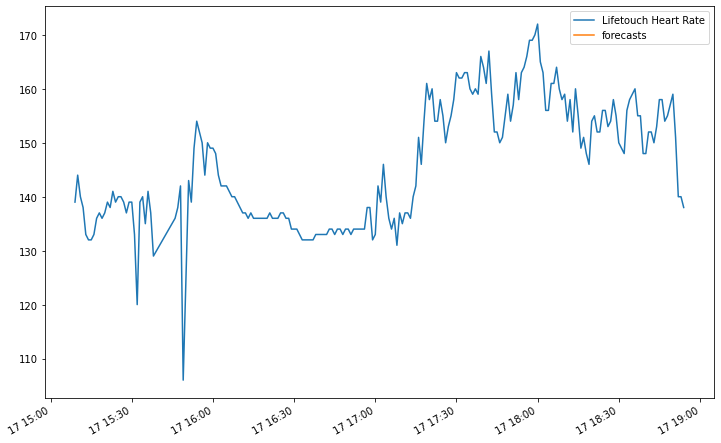

In [ ]:
future_data['forecasts'] = results.predict(start=218, end=237, dynamic=True)
future_data[['Lifetouch Heart Rate','forecasts']].plot(figsize=(12,8))